In [15]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
month = 'jan'
month_num = '01'

In [3]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [4]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [5]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [6]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')

In [7]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [8]:
height = pd.read_excel('gc_altitude.xlsx')

In [9]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [10]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [16]:
for ds in [ds_emispulse, ds_emisbase,ds_emis2x]:
    utils.combine_BC(ds)

In [20]:
Ndt = 60
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


In [69]:
coal_emis_annual = 4535.924 #metric tons 
tons_to_kg = 1000
coal_emis_annual*= tons_to_kg/365

In [70]:
coal_emis_time = xr.Dataset(
    data_vars = dict(emissions = (['time'], np.repeat(coal_emis_annual, len(t_range)))),
    coords = dict(time = t_range),
    )

In [71]:
f = coal_emis_time['emissions']
G = (utils.global_w_mean(ds_delta, 'AerMassBC') - 
     utils.global_w_mean(ds_base, 'AerMassBC'))
G = G.assign_coords(time = np.arange(0,len(G['time'])))

f0 = (utils.global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      utils.global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)

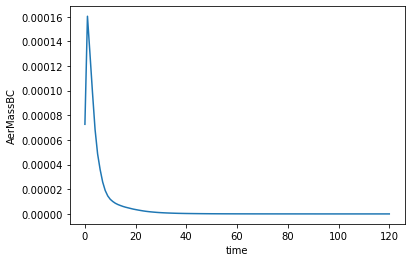

In [30]:
G.plot()

In [31]:
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)


In [42]:
for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0,ds_output = False)
        


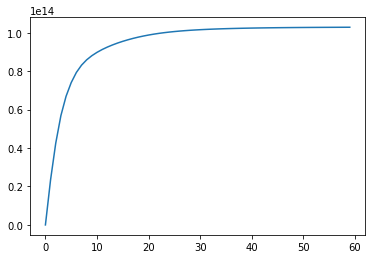

In [43]:
plt.plot(C_df.sum(axis = 1));

#plt.ylim(0,1.2e-9)

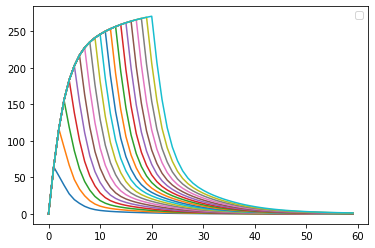

In [75]:
((C_df/365).cumsum(axis = 1)[C_df.cumsum(axis = 1).columns[0:20]]/1e9).plot()
plt.legend('')

In [ ]:
#6.5 tg annual global

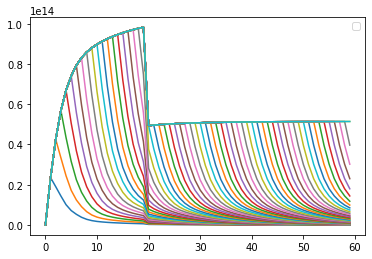

In [68]:
pd.concat([C_df[:19],C_df[20:]*.5]).cumsum(axis = 1).plot()
plt.legend('')